# Genetic Algorithm for Substitution Cipher Decoding
## 1. Problem Overview
A **Substitution Cipher** replaces each letter of the alphabet with another letter. For the English alphabet, there are $26!$ (approximately $4 \times 10^{26}$) possible keys, making a brute-force search impossible. 

In this project, we use a **Genetic Algorithm (GA)** to evolve a population of potential keys (chromosomes). The "fitness" of each key is determined by how much "sense" the decoded text makes, which we evaluate using a pre-built dictionary from a large corpus of English text.

## 2. Dataset Preparation and Cleaning
To evaluate a decoded text, we need a reference dictionary. We use `global_text.txt` to extract valid English words. The cleaning pipeline involves:
- Lowercasing all text.
- Removing non-alphabetic characters (punctuation and numbers).
- Filtering out very short words or common stop words (optional but helpful).

In [3]:
import re
import string
import random

def clean_text(text):
    """
    Normalizes text by lowercasing and removing non-alphabetic characters.
    """
    text = text.lower()
    # Replace anything that is not a-z or space with a space
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Remove extra whitespaces
    text = " ".join(text.split())
    return text

# Load the corpus to build the dictionary
with open('global_text.txt', 'r', encoding='utf-8') as f:
    raw_corpus = f.read()

cleaned_corpus = clean_text(raw_corpus)
# Create a set of unique words for O(1) lookup
dictionary = set(cleaned_corpus.split())

print(f"Dictionary built with {len(dictionary)} unique words.")

Dictionary built with 1827 unique words.


## 3. Chromosome Representation
A **Chromosome** is represented as a list of 26 unique characters, where the index corresponds to the alphabet (0='a', 1='b', ..., 25='z'). 
For example, if the chromosome is `['d', 'a', 'c', ...]`, it means:
- 'a' in encoded text -> 'd' in decoded text
- 'b' in encoded text -> 'a' in decoded text

In [4]:
class Chromosome:
    def __init__(self, key=None):
        self.alphabet = list(string.ascii_lowercase)
        if key is None:
            # Random initial key
            self.key = list(string.ascii_lowercase)
            random.shuffle(self.key)
        else:
            self.key = key
        self.fitness = 0

    def decode(self, encoded_text):
        """
        Decodes the text using this chromosome's key.
        """
        # Create a translation table for speed
        table = str.maketrans(string.ascii_lowercase, "".join(self.key))
        # Keep original case and punctuation by only translating lowercase
        return encoded_text.lower().translate(table)

def initialize_population(pop_size):
    return [Chromosome() for _ in range(pop_size)]

# Example check
example_pop = initialize_population(10)
print(f"Generated {len(example_pop)} random chromosomes.")

Generated 10 random chromosomes.


## 4. Fitness Evaluation
The fitness function measures the quality of a chromosome. We decode the target text using the chromosome's key and count how many words in the resulting text exist in our dictionary.
Higher word matches = Higher fitness.

In [5]:
def calculate_fitness(chromosome, encoded_text, dictionary):
    decoded_text = chromosome.decode(encoded_text)
    words = decoded_text.split()
    if not words:
        return 0
    
    match_count = 0
    for word in words:
        if word in dictionary:
            # We can weight longer words more heavily
            match_count += len(word) ** 2 
            
    chromosome.fitness = match_count
    return match_count

# Load the actual text we want to decode
with open('encoded_text.txt', 'r', encoding='utf-8') as f:
    target_encoded_text = f.read()

# Test fitness for one random chromosome
test_chrom = Chromosome()
score = calculate_fitness(test_chrom, target_encoded_text, dictionary)
print(f"Random Chromosome Fitness Score: {score}")

Random Chromosome Fitness Score: 20


## 5. Decoder Class Infrastructure
Following the project requirements, we encapsulate the logic into a `Decoder` class. 
The `decode()` method will eventually contain the full GA loop (Selection, Crossover, Mutation).

In [6]:
class Decoder:
    def __init__(self, encoded_text):
        self.encoded_text = encoded_text
        self.clean_encoded = clean_text(encoded_text)
        # Pre-built dictionary (should be loaded or passed)
        self.dictionary = dictionary 
        
    def decode(self):
        """
        Main Genetic Algorithm Loop.
        Returns the best decoded string found.
        """
        # Placeholder for GA implementation
        # 1. Initialize Population
        # 2. While not converged:
        #    a. Calculate Fitness
        #    b. Selection
        #    c. Crossover & Mutation
        
        # For now, returns a dummy placeholder or random try
        best_candidate = Chromosome()
        return best_candidate.decode(self.encoded_text)

# Testing the structure
d = Decoder(target_encoded_text)
print("Decoder initialized. Ready for GA implementation.")

Decoder initialized. Ready for GA implementation.


## 6. Genetic Operators (Permutation-Safe)
Standard crossover methods can create duplicate letters in a key. To maintain a valid permutation of the 26-letter alphabet, we implement:
- **Ordered Crossover (OX):** Inherits a segment from one parent and fills the rest from the second parent while preserving order and avoiding duplicates.
- **Swap Mutation:** Randomly swaps two letters in the key to introduce genetic diversity.

In [7]:
def ordered_crossover(parent1, parent2):
    """
    Performs Ordered Crossover (OX) on two parent chromosomes.
    """
    size = len(parent1.key)
    # Select two random points for the segment
    start, end = sorted(random.sample(range(size), 2))
    
    # Child 1 segment from Parent 1
    child1_key = [None] * size
    child1_key[start:end] = parent1.key[start:end]
    
    # Fill remaining from Parent 2
    p2_idx = 0
    for i in range(size):
        if child1_key[i] is None:
            while parent2.key[p2_idx] in child1_key:
                p2_idx += 1
            child1_key[i] = parent2.key[p2_idx]
            
    # Repeat for Child 2 (segment from Parent 2, fill from Parent 1)
    child2_key = [None] * size
    child2_key[start:end] = parent2.key[start:end]
    
    p1_idx = 0
    for i in range(size):
        if child2_key[i] is None:
            while parent1.key[p1_idx] in child2_key:
                p1_idx += 1
            child2_key[i] = parent1.key[p1_idx]
            
    return Chromosome(child1_key), Chromosome(child2_key)

def swap_mutation(chromosome, mutation_rate=0.1):
    """
    Randomly swaps two genes (letters) in the key based on mutation_rate.
    """
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(chromosome.key)), 2)
        chromosome.key[idx1], chromosome.key[idx2] = chromosome.key[idx2], chromosome.key[idx1]

## 7. Synthetic Integration Test
This test verifies all implemented components:
1. Creating a small dummy dictionary.
2. Creating an encoded string with a known key.
3. Testing if a "correct" chromosome gets a higher score than a random one.
4. Testing crossover and mutation.

In [8]:
# 1. Setup small environment
test_dict = {"hello", "world", "this", "is", "genetic", "algorithm"}
test_encoded = "itssg ksgit" # Let's say it means "hello world" with a specific key

# 2. Create a "Perfect" Chromosome for this specific mapping
# Let's assume 'i'->'h', 't'->'e', 's'->'l', 'g'->'o', 'k'->'w', 'r'->'d'
perfect_key = list(string.ascii_lowercase)
# Manual mapping for "hello world"
mapping = {'i':'h', 't':'e', 's':'l', 'g':'o', 'k':'w'}
for enc, dec in mapping.items():
    idx = string.ascii_lowercase.index(enc)
    perfect_key[idx] = dec

perfect_chrom = Chromosome(perfect_key)
random_chrom = Chromosome()

# 3. Compare Fitness
perfect_score = calculate_fitness(perfect_chrom, test_encoded, test_dict)
random_score = calculate_fitness(random_chrom, test_encoded, test_dict)

print(f"Decoded with Perfect Key: '{perfect_chrom.decode(test_encoded)}'")
print(f"Perfect Key Score: {perfect_score}")
print(f"Random Key Score: {random_score}")

# 4. Test Crossover
p1, p2 = Chromosome(), Chromosome()
c1, c2 = ordered_crossover(p1, p2)
print(f"\nCrossover check: Child1 is valid permutation? {len(set(c1.key)) == 26}")

# 5. Test Mutation
before_mut = list(c1.key)
swap_mutation(c1, mutation_rate=1.0) # Force mutation
after_mut = c1.key
print(f"Mutation check: Key changed? {before_mut != after_mut}")

Decoded with Perfect Key: 'hello wlohe'
Perfect Key Score: 25
Random Key Score: 0

Crossover check: Child1 is valid permutation? True
Mutation check: Key changed? True


## 8. Main Evolutionary Loop and Selection
To transition from one generation to the next, we need to select the best-performing individuals to act as parents. We use **Tournament Selection** or **Elite Selection** to ensure that high-fitness genes are preserved while maintaining diversity.

### Evolution Process:
1. **Selection:** Choose the best chromosomes based on their fitness scores.
2. **Crossover:** Pair parents to produce offspring using Ordered Crossover (OX).
3. **Mutation:** Apply Swap Mutation to offspring to explore new areas of the search space.
4. **Replacement:** Form a new population for the next generation.

In [9]:
def select_parents(population, num_parents):
    """
    Selects the top-performing individuals as parents (Elitism).
    """
    population.sort(key=lambda x: x.fitness, reverse=True)
    return population[:num_parents]

def evolve(population, encoded_text, dictionary, pop_size, mutation_rate=0.1):
    # 1. Selection
    num_parents = pop_size // 2
    parents = select_parents(population, num_parents)
    
    new_population = []
    # Keep the best parent (Elitism)
    new_population.append(parents[0])
    
    # 2. Crossover & Mutation to fill the rest of the population
    while len(new_population) < pop_size:
        p1, p2 = random.sample(parents, 2)
        child1, child2 = ordered_crossover(p1, p2)
        
        swap_mutation(child1, mutation_rate)
        swap_mutation(child2, mutation_rate)
        
        new_population.extend([child1, child2])
        
    # 3. Trim to exact population size and calculate fitness
    new_population = new_population[:pop_size]
    for chrom in new_population:
        calculate_fitness(chrom, encoded_text, dictionary)
        
    return new_population

In [10]:
# Hyperparameters
POP_SIZE = 500
GENERATIONS = 200
MUTATION_RATE = 0.2

# Initialization
population = initialize_population(POP_SIZE)
for chrom in population:
    calculate_fitness(chrom, target_encoded_text, dictionary)

# Optimization Loop
for gen in range(GENERATIONS):
    population = evolve(population, target_encoded_text, dictionary, POP_SIZE, MUTATION_RATE)
    best_fitness = population[0].fitness
    
    if gen % 10 == 0:
        print(f"Generation {gen}: Best Fitness = {best_fitness}")
        # Show a snippet of the current best decoding
        print(f"Preview: {population[0].decode(target_encoded_text)[:70]}...")

print("\nFinal Best Decoding:")
print(population[0].decode(target_encoded_text))

Generation 0: Best Fitness = 367
Preview: yokb tubvnabu ntkwkagees muee kayn g qky qciluy.  k'z tuvnbykaw ky
xcb...
Generation 10: Best Fitness = 460
Preview: seum pymcgbmy gpuoubtrrn wyrr ubsg t vus vhzxys.  u'a pycgmsubo us
lhm...
Generation 20: Best Fitness = 469
Preview: tarf wnfohvfn hwrsrvpyyu gnyy rvth p irt icbjnt.  r'q wnohftrvs rt
lcf...
Generation 30: Best Fitness = 520
Preview: teoa jlaphnal hjoronxqqf glqq onth x kot kuwilt.  o'm jlphatonr ot
dua...
Generation 40: Best Fitness = 674
Preview: thid mqdxofdq ominifavvu kqvv ifto a eit ebrgqt.  i'j mqxodtifn it
wbd...
Generation 50: Best Fitness = 687
Preview: thid vqdxofdq ovinifammu kqmm ifto a eit ebrgqt.  i's vqxodtifn it
lbd...
Generation 60: Best Fitness = 692
Preview: thid vqdxofdq ovinifammu kqmm ifto a eit ebrgqt.  i'c vqxodtifn it
sbd...
Generation 70: Best Fitness = 790
Preview: thbk pekwimke ipbgbmavvr fevv bmti a zbt zqdoet.  b'x pewiktbmg bt
jqk...
Generation 80: Best Fitness = 790
Preview: thbk pekwimke ipbgbmav

## 9. Analyzing Operators: Crossover vs. Mutation
To verify the claims in part (B), we run two controlled experiments:
1. **Mutation Only:** Setting crossover probability to 0.
2. **Crossover Only:** Setting mutation rate to 0.

In [11]:
def run_experiment(mode="both", generations=100):
    pop_size = 200
    population = initialize_population(pop_size)
    
    # Initial fitness
    for chrom in population:
        calculate_fitness(chrom, target_encoded_text, dictionary)
        
    history = []
    
    for gen in range(generations):
        # Selection
        parents = select_parents(population, pop_size // 2)
        new_pop = [parents[0]] # Elitism
        
        while len(new_pop) < pop_size:
            p1, p2 = random.sample(parents, 2)
            
            if mode == "mutation_only":
                # No crossover, just clone and mutate
                child = Chromosome(list(p1.key))
                swap_mutation(child, mutation_rate=0.2)
                new_pop.append(child)
            
            elif mode == "crossover_only":
                # Crossover without mutation
                child1, child2 = ordered_crossover(p1, p2)
                new_pop.extend([child1, child2])
            
            else: # Standard GA
                child1, child2 = ordered_crossover(p1, p2)
                swap_mutation(child1, 0.2)
                swap_mutation(child2, 0.2)
                new_pop.extend([child1, child2])
        
        population = new_pop[:pop_size]
        for chrom in population:
            calculate_fitness(chrom, target_encoded_text, dictionary)
        
        history.append(population[0].fitness)
    
    return history

# Running the experiments
history_mutation = run_experiment(mode="mutation_only")
history_crossover = run_experiment(mode="crossover_only")
history_both = run_experiment(mode="both")

print("Experiment Finished.")

Experiment Finished.


## 10. Performance Analysis: Speed vs. Accuracy
To answer part (C), we compare three configurations:
1. **Balanced GA:** Both Crossover and Mutation (Standard).
2. **Crossover Heavy:** Focuses on recombination to show convergence speed.
3. **Mutation Heavy:** Focuses on small changes to show fine-tuning and accuracy.

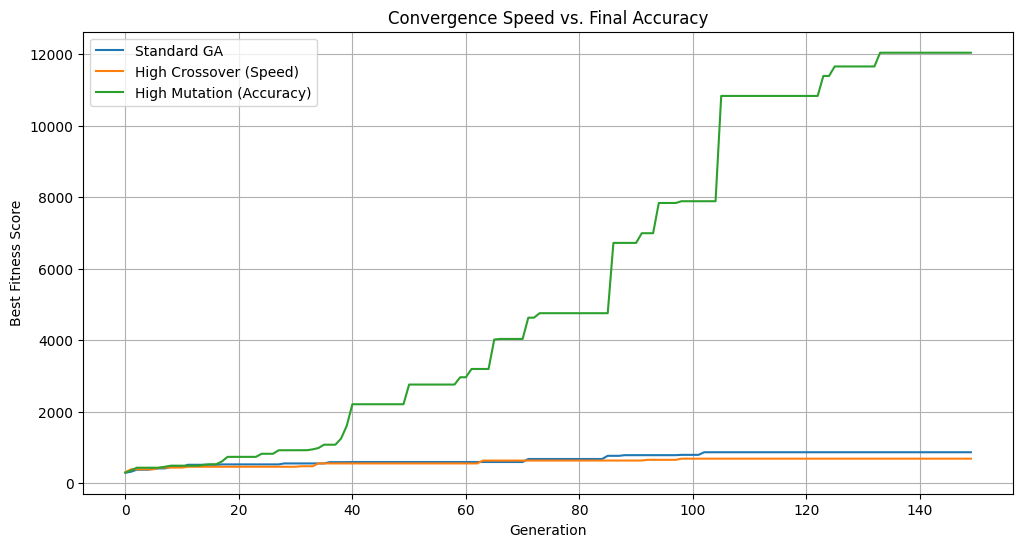

In [12]:
import matplotlib.pyplot as plt

def run_performance_test(pop_size=300, generations=150):
    # Configurations: (Crossover_Prob, Mutation_Rate)
    configs = {
        'Standard GA': (0.8, 0.2),
        'High Crossover (Speed)': (1.0, 0.05),
        'High Mutation (Accuracy)': (0.4, 0.5)
    }
    
    results = {}

    for label, (cross_p, mut_r) in configs.items():
        population = initialize_population(pop_size)
        for chrom in population: calculate_fitness(chrom, target_encoded_text, dictionary)
        
        history = []
        for gen in range(generations):
            population.sort(key=lambda x: x.fitness, reverse=True)
            history.append(population[0].fitness)
            
            new_pop = population[:2] # Elitism
            while len(new_pop) < pop_size:
                p1, p2 = random.sample(population[:pop_size//2], 2)
                
                # Crossover logic based on probability
                if random.random() < cross_p:
                    c1, c2 = ordered_crossover(p1, p2)
                else:
                    c1, c2 = Chromosome(list(p1.key)), Chromosome(list(p2.key))
                
                swap_mutation(c1, mut_r)
                swap_mutation(c2, mut_r)
                new_pop.extend([c1, c2])
            
            population = new_pop[:pop_size]
            for chrom in population: calculate_fitness(chrom, target_encoded_text, dictionary)
            
        results[label] = history
    return results

# Run and Plot
history_data = run_performance_test()

plt.figure(figsize=(12, 6))
for label, data in history_data.items():
    plt.plot(data, label=label)

plt.title("Convergence Speed vs. Final Accuracy")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.legend()
plt.grid(True)
plt.show()

## 11. Addressing Stagnation (Part T)
Stagnation occurs when the population loses diversity and the fitness score stops improving. 
To overcome this, we implement several strategies:
1. **Adaptive Mutation Rate:** Increasing mutation when fitness stays constant.
2. **Random Immigrants:** Replacing part of the population with random new members.
3. **Inversion Mutation:** A specialized mutation that reverses a sub-segment of the key.

In [13]:
def inversion_mutation(chromosome):
    """
    Selects two points and reverses the segment between them.
    More powerful than simple swap for escaping local optima.
    """
    idx1, idx2 = sorted(random.sample(range(len(chromosome.key)), 2))
    chromosome.key[idx1:idx2] = reversed(chromosome.key[idx1:idx2])

def evolve_with_recovery(population, encoded_text, dictionary, pop_size, 
                         mutation_rate, stagnation_count):
    population.sort(key=lambda x: x.fitness, reverse=True)
    
    # Adaptive Mutation: Increase mutation if we are stuck
    current_mut_rate = mutation_rate
    if stagnation_count > 15:
        current_mut_rate = min(current_mut_rate * 2, 0.6)
        
    new_pop = population[:5] # Keep top 5 (Elitism)
    
    # Random Immigrants: If stuck for too long, inject fresh blood
    if stagnation_count > 30:
        for _ in range(pop_size // 10):
            new_pop.append(Chromosome())
            
    while len(new_pop) < pop_size:
        p1, p2 = random.sample(population[:pop_size//2], 2)
        child1, child2 = ordered_crossover(p1, p2)
        
        # Apply standard or inversion mutation
        if random.random() < 0.5:
            swap_mutation(child1, current_mut_rate)
            swap_mutation(child2, current_mut_rate)
        else:
            if random.random() < current_mut_rate:
                inversion_mutation(child1)
                inversion_mutation(child2)
                
        new_pop.extend([child1, child2])
        
    new_pop = new_pop[:pop_size]
    for chrom in new_pop:
        calculate_fitness(chrom, encoded_text, dictionary)
    return new_pop

# Execution with Stagnation Tracking
population = initialize_population(500)
best_ever_fitness = 0
stagnation_count = 0

for gen in range(250):
    population = evolve_with_recovery(population, target_encoded_text, dictionary, 
                                     500, 0.2, stagnation_count)
    
    if population[0].fitness > best_ever_fitness:
        best_ever_fitness = population[0].fitness
        stagnation_count = 0
    else:
        stagnation_count += 1
        
    if gen % 20 == 0:
        print(f"Gen {gen} | Fitness: {best_ever_fitness} | Stagnation: {stagnation_count}")

print("\nFinal Best Output after Recovery Strategies:")
print(population[0].decode(target_encoded_text)[:300])

Gen 0 | Fitness: 20 | Stagnation: 0
Gen 20 | Fitness: 563 | Stagnation: 1
Gen 40 | Fitness: 579 | Stagnation: 19
Gen 60 | Fitness: 631 | Stagnation: 4
Gen 80 | Fitness: 655 | Stagnation: 13
Gen 100 | Fitness: 740 | Stagnation: 12
Gen 120 | Fitness: 741 | Stagnation: 13
Gen 140 | Fitness: 741 | Stagnation: 33
Gen 160 | Fitness: 741 | Stagnation: 53
Gen 180 | Fitness: 786 | Stagnation: 19
Gen 200 | Fitness: 786 | Stagnation: 39
Gen 220 | Fitness: 795 | Stagnation: 5
Gen 240 | Fitness: 795 | Stagnation: 25

Final Best Output after Recovery Strategies:
dasb eybvogby oesnsgjuuc ryuu sgdo j isd imxpyd.  s'k eyvobdsgn sd
zmbd bo isuu toybg'd dasgp s'k sngoesgn ask.

sg jedsxuy <x4w5vh.zqt@tjepbsty.obeay.mopgoe.ytm> isu@opxroemk.obeay.ytm (isuu xoggye) wesdyb:
>zsk vyeec (vyeec@tbsgx.xok) weody:
>
>[boky bdmrr jiomd isiusxju koejusdc, daomna isuu'b fm


## 12. Swarm Intelligence for Substitution Cipher
### Concept Overview
While Genetic Algorithms use evolution, Swarm Intelligence relies on collective behavior. 
- **ACO (Ant Colony Optimization):** Highly suitable. The problem can be modeled as finding the best path in a bipartite graph where each node in Set A (Ciphertext letters) must be connected to exactly one node in Set B (Plaintext letters).
- **PSO (Particle Swarm Optimization):** Less intuitive for discrete permutations, but possible using "Swap Operators" to define velocity and position in a discrete space.

### ACO Strategy for Decoding:
1. **Ants:** Each ant constructs a full 26-letter key (a path).
2. **Pheromones:** A 26x26 matrix where $P[i][j]$ represents the collective "desire" to map encoded letter $i$ to decoded letter $j$.
3. **Heuristic:** Frequency analysis of the English language (e.g., the letter 'e' is the most common).
4. **Path Construction:** Ants choose mappings based on pheromone intensity and heuristic information.

In [14]:
import numpy as np

class ACO_Decoder:
    def __init__(self, encoded_text, dictionary, n_ants=30, alpha=1.0, beta=2.0, evaporation=0.5):
        self.encoded_text = encoded_text
        self.dictionary = dictionary
        self.n_ants = n_ants
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic importance (we'll use frequency later)
        self.evaporation = evaporation
        self.alphabet = list(string.ascii_lowercase)
        
        # Initialize pheromones uniformly
        self.pheromones = np.ones((26, 26)) 
        
    def get_fitness(self, key_list):
        chrom = Chromosome(key_list)
        return calculate_fitness(chrom, self.encoded_text, self.dictionary)

    def construct_solution(self):
        key = [None] * 26
        available_chars = list(string.ascii_lowercase)
        
        for i in range(26):
            # Calculate probabilities for mapping current index (alphabet[i]) 
            # to any of the available_chars
            probs = []
            for char in available_chars:
                j = self.alphabet.index(char)
                prob = (self.pheromones[i][j] ** self.alpha)
                probs.append(prob)
            
            probs = np.array(probs) / sum(probs)
            # Choose a mapping based on probability
            chosen_char = np.random.choice(available_chars, p=probs)
            key[i] = chosen_char
            available_chars.remove(chosen_char)
        return key

    def run(self, iterations=100):
        best_key = None
        best_fitness = -1
        
        for iteration in range(iterations):
            solutions = []
            for _ in range(self.n_ants):
                key = self.construct_solution()
                fitness = self.get_fitness(key)
                solutions.append((key, fitness))
                
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_key = key
            
            # Evaporate pheromones
            self.pheromones *= (1 - self.evaporation)
            
            # Update pheromones based on solutions
            for key, fitness in solutions:
                reward = fitness / (best_fitness + 1e-9) # Normalized reward
                for i, char in enumerate(key):
                    j = self.alphabet.index(char)
                    self.pheromones[i][j] += reward
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration} | Best Fitness: {best_fitness}")
        
        return Chromosome(best_key).decode(self.encoded_text)

# Running ACO
aco = ACO_Decoder(target_encoded_text, dictionary, n_ants=20)
aco_decoded_text = aco.run(iterations=50)
print("\nFinal ACO Decoding Sample:")
print(aco_decoded_text[:200])

Iteration 0 | Best Fitness: 140
Iteration 10 | Best Fitness: 268
Iteration 20 | Best Fitness: 288
Iteration 30 | Best Fitness: 366
Iteration 40 | Best Fitness: 456

Final ACO Decoding Sample:
tran uynjisny iuawaskffb gyff asti k vat vhloyt.  a'm uyjintasw at
xhnt ni vaff eiyns't traso a'm awsiuasw ram.

as kutalfy <l4p5jq.xze@ekuonaey.inury.hiosiu.yeh> vaf@iolgiuhm.inury.yeh (vaff lissyu) 
